In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from models.evaluation import utils
from utils import eval_methods, dataLoader, simple_metric

# from configs.mts_style_transfer_v2.args import DafaultArguments as args
from configs.mts_style_transfer_v2.args_sim import DafaultArguments as args
# from configs.mts_style_transfer_v2.args_real import DafaultArguments as args

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import umap
from sklearn.manifold import TSNE

/home/henri/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
MODEL_TO_EVALUATE = "to_evaluate/exp_folder copy/MTS-ST V2 Amplitude 20e smaller ce"

In [7]:
def predictions_on_content_space(content_dset_path:str, content_encoder:tf.keras.Model, data_loading_arguments:dict):

    dset_content_train, dset_content_valid = utils.load_dset(content_dset_path, data_loading_arguments, drop_labels=False)

    dset_content_train= utils.encode_dataset(dset_content_train, content_encoder, data_loading_arguments)
    dset_content_valid= utils.encode_dataset(dset_content_valid, content_encoder, data_loading_arguments)

    content_perf = eval_methods.predictions_on_content_space(dset_content_train, dset_content_valid, data_loading_arguments)

    return content_perf

def load_valid_batches(content_dataset_path:str, style_dataset_path:str):
    default_parameters = args()

    sequence_length = default_parameters.simulated_arguments.sequence_lenght_in_sample
    gran = default_parameters.simulated_arguments.granularity
    overlap = default_parameters.simulated_arguments.overlap
    bs = 64
    _, content_dset_valid = dataLoader.loading_wrapper(
        content_dataset_path,
        sequence_length, 
        gran, 
        overlap, 
        bs)
    
    _, style_dset_valid =  dataLoader.loading_wrapper(
        style_dataset_path, 
        sequence_length, 
        gran, 
        overlap,
        bs)
    
    
    content_batch = dataLoader.get_batches(content_dset_valid, 50)
    style_batch = dataLoader.get_batches(style_dset_valid, 50) 
    
    return content_batch, style_batch

def generate(content_batch, style_batch, content_encoder, style_encoder, decoder):
    
    content = content_encoder(content_batch, training=False)
    style = style_encoder(style_batch, training=False)
    generated = decoder([content, style], training=False)
    
    generated = tf.concat(generated, -1)
    
    return generated

# Evaluate Trained Dataset

In [8]:
default_arguments = args()
training_arguments = utils.get_model_training_arguments(MODEL_TO_EVALUATE)
ce, se, de = utils.load_models(MODEL_TO_EVALUATE)

# Generation quality.
## Generate a "dataset" for each style.

In [9]:
def get_name(path:str):
    filename = path.split("/")[-1]
    return ".".join(filename.split('.')[:-1])

In [10]:
def stylize(
        content_dset:tf.data.Dataset, 
        style_sequence:tf.Tensor, 
        content_encoder:tf.keras.Model, 
        style_encoder:tf.keras.Model, 
        decoder:tf.keras.Model, args:dict) -> tf.data.Dataset:
    
    label_idx = int(args.simulated_arguments.sequence_lenght_in_sample//2)

    content_space = content_dset.map(lambda seq, _: (content_encoder(seq)))
    labels = content_dset.map(lambda _,l : l)
    
    style_vector = style_encoder(style_sequence)

    translated = content_space.map(lambda c: tf.concat(decoder([c, style_vector], training=False), -1))
    dset_final = tf.data.Dataset.zip((translated, labels))

    return dset_final


In [11]:
real_style_dataset = {}
fake_style_dataset = {}
style_names = []
bs = args().simulated_arguments.batch_size

dset_content_train, dset_content_valid = utils.load_dset(training_arguments["dset_content"], default_arguments, drop_labels=False)

dset_content_train = utils.extract_labels(dset_content_train, default_arguments)
dset_content_valid = utils.extract_labels(dset_content_valid, default_arguments)

for style_path in training_arguments["style_datasets"]:
    sty_name = get_name(style_path)
    style_names.append(sty_name)
    
    print(f"Making {sty_name}")
    
    dset_style_train, dset_style_valid = utils.load_dset(style_path, default_arguments, drop_labels=False)
    
    dset_lstyle_train = utils.extract_labels(dset_style_train, default_arguments)
    dset_lstyle_valid = utils.extract_labels(dset_style_valid, default_arguments)
    
    real_style_dataset[f"{sty_name}_train"] = dset_lstyle_train
    real_style_dataset[f"{sty_name}_valid"] = dset_lstyle_valid
    
    style_batch_train = next(iter(dset_lstyle_train))[0][0]
    style_batch_train = np.array([style_batch_train]* bs)
    
    style_batch_valid = next(iter(dset_lstyle_valid))[0][0]
    style_batch_valid = np.array([style_batch_valid]* bs)
            
    stylized_train = stylize(dset_content_train, style_batch_train, ce, se, de, default_arguments)
    stylized_valid = stylize(dset_content_valid, style_batch_valid, ce, se, de, default_arguments)
    
    fake_style_dataset[f"{sty_name}_train"] = stylized_train
    fake_style_dataset[f"{sty_name}_valid"] = stylized_valid
    

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Making 1.0_1.0
Making 2.0_2.0
Making 3.0_3.0
Making 4.0_4.0
Making 5.0_5.0
Making 6.0_6.0
Making 7.0_7.0
Making 8.0_8.0
Making 9.0_9.0
Making 10.0_10.0


# Some Generations.

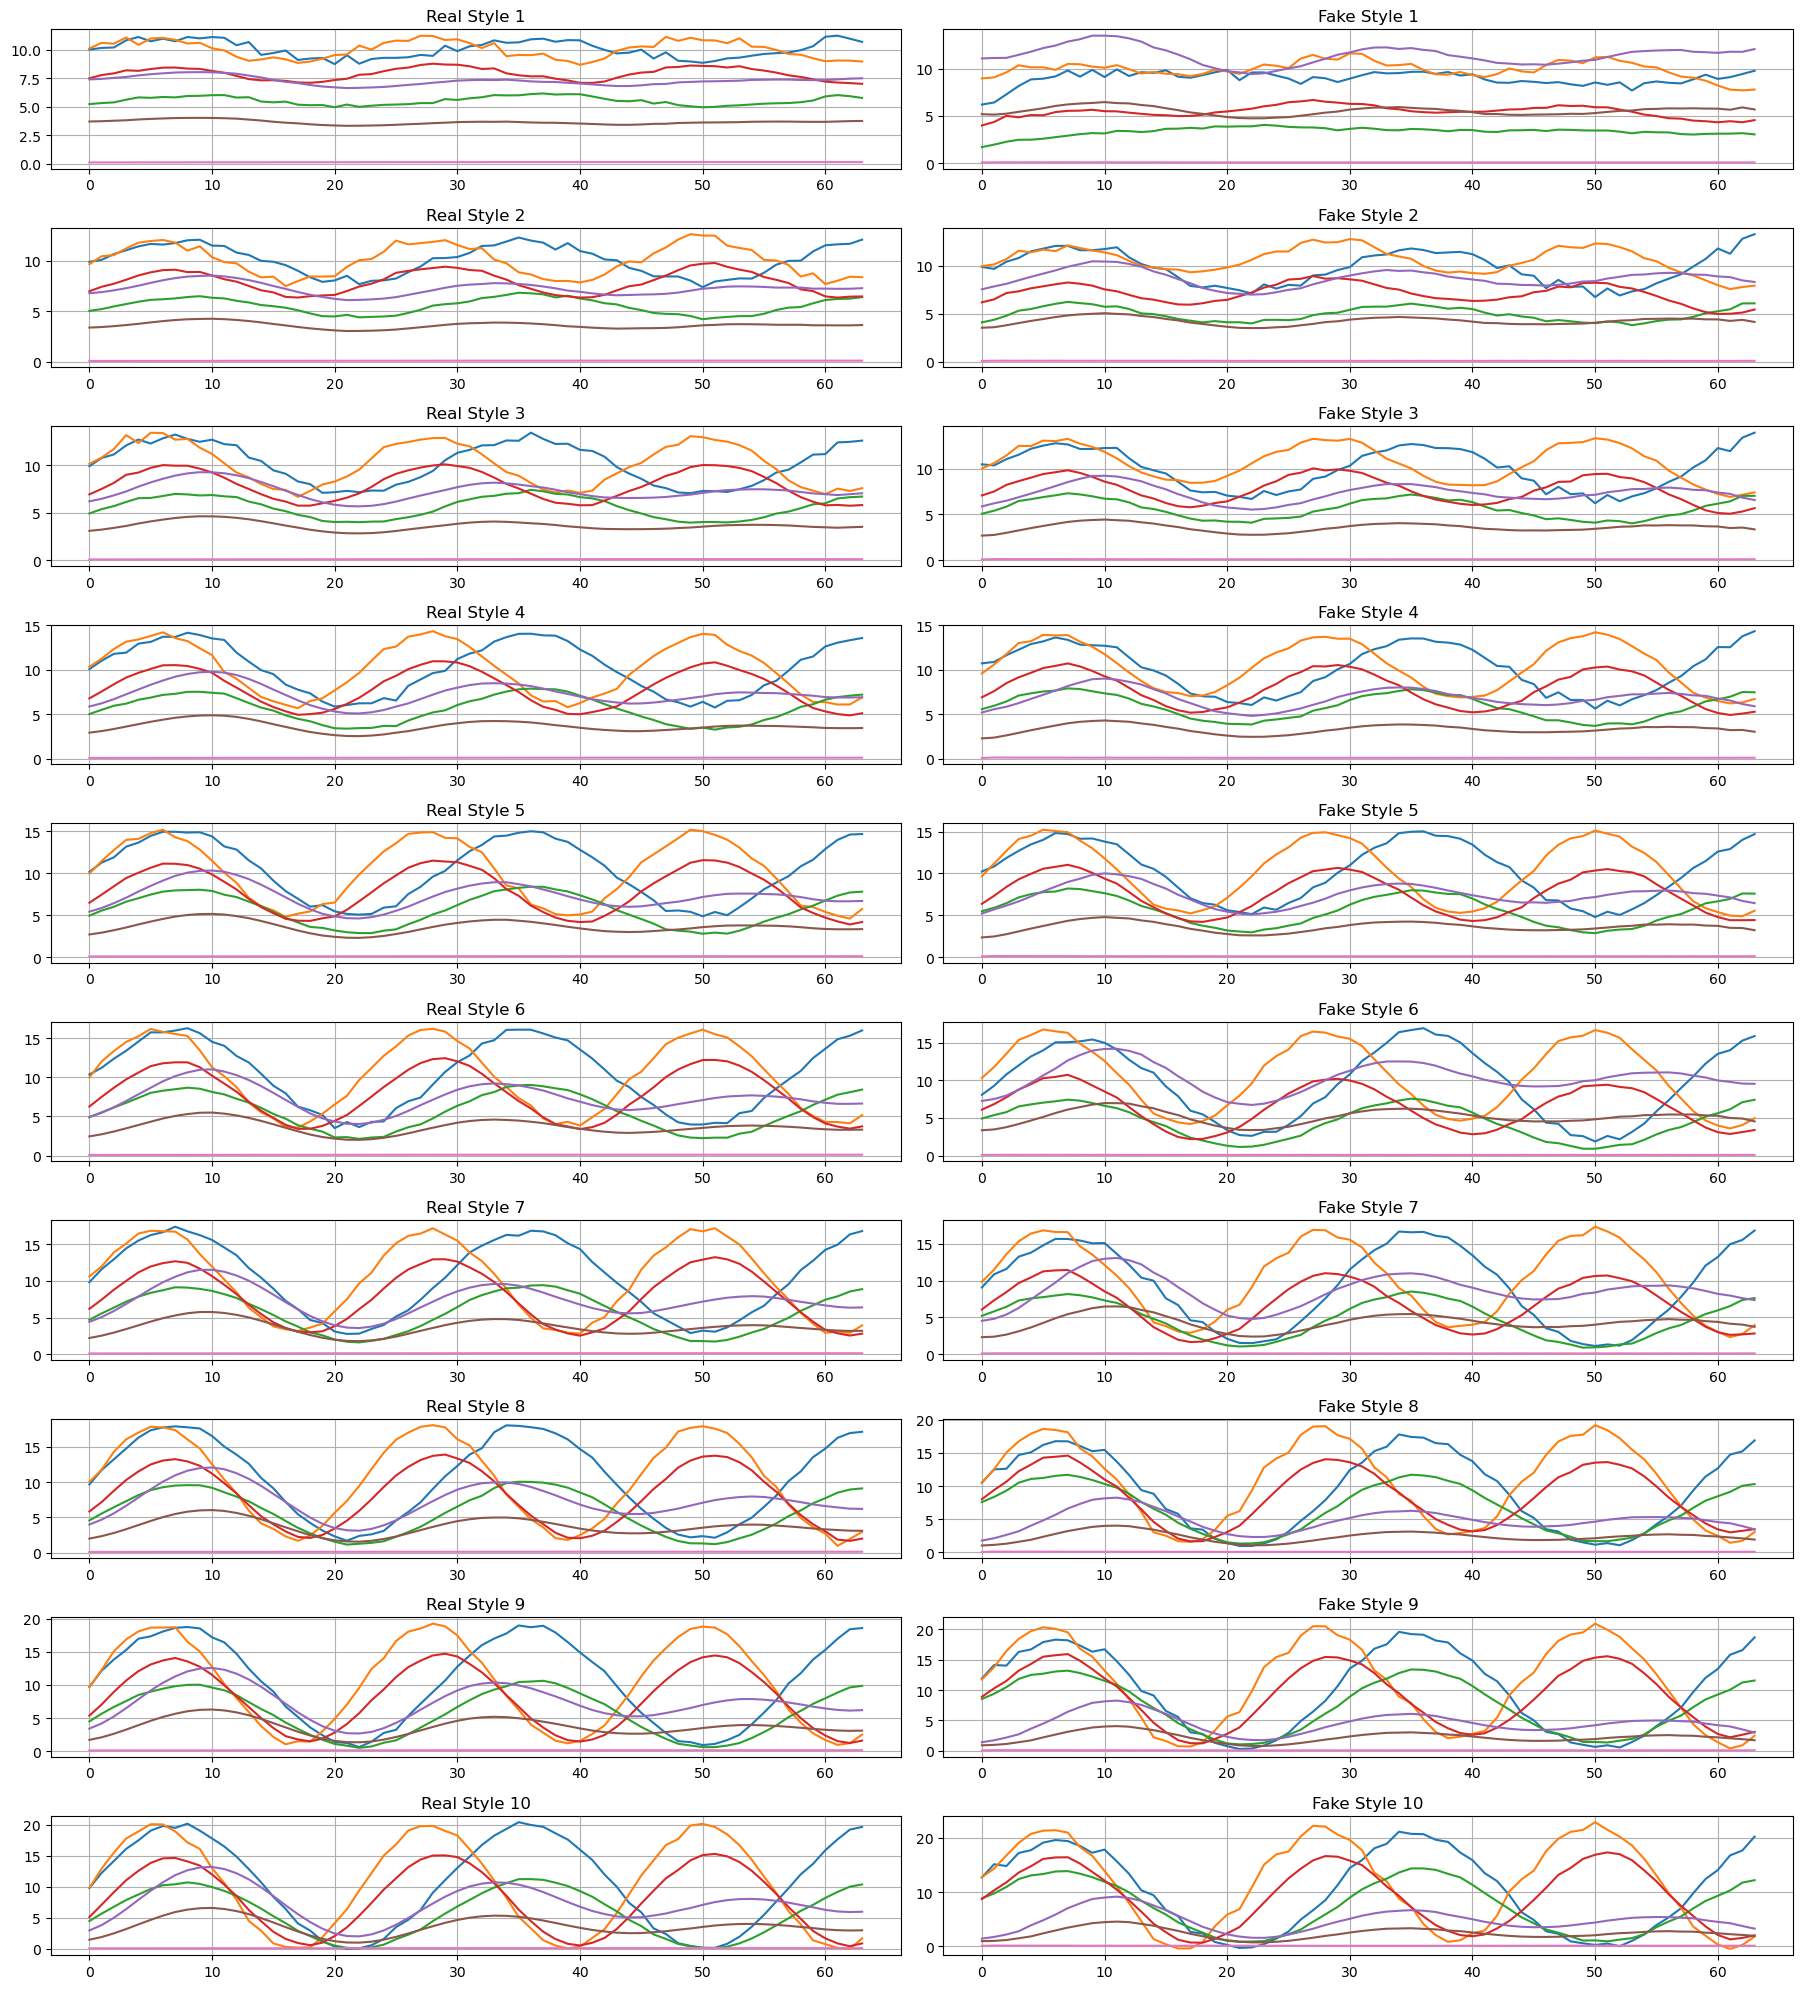

In [12]:
plt.figure(figsize=(18, 20))


for i, style_ in enumerate(style_names):
    real_style_sequence = next(iter(real_style_dataset[f"{style_}_valid"]))[0][0]
    fake_style_sequence = next(iter(fake_style_dataset[f"{style_}_valid"]))[0][0]
    
    
    ax = plt.subplot(len(style_names), 2, 2*i+1)
    ax.set_title(f"Real Style {i+1}")
    plt.plot(real_style_sequence)
    ax.grid(True)
    
        
    ax = plt.subplot(len(style_names), 2, 2*i+2)
    ax.set_title(f"Fake Style {i+1}")
    
    plt.plot(fake_style_sequence)
    
    ax.grid(True)
    
plt.tight_layout()
    

# TSTR

In [13]:
def tstr(
    dset_train_real,
    dset_valid_real,
    dset_train_fake):

    print('[+] Train on Real.')
    real_performances, hist_real = eval_methods.train_naive_discriminator(dset_train_real, dset_valid_real, args(), epochs=1, n_classes=5)

    print("[+] Train on Synthetic.")
    gen_performances, hist_fake = eval_methods.train_naive_discriminator(dset_train_fake, dset_valid_real, args(), epochs=1, n_classes=5)
    return real_performances, gen_performances

In [14]:
tstr_stats = {}

for i, style_ in enumerate(style_names):
    print(f'[+] Training on dataset {style_}.')
    
    perf_on_real, perf_on_fake = tstr(
        real_style_dataset[f"{style_}_train"],
        real_style_dataset[f"{style_}_valid"],
        fake_style_dataset[f"{style_}_train"],
        )
    
    tstr_stats[f"{style_}_real"] = [perf_on_real]
    tstr_stats[f"{style_}_gen"] = [perf_on_fake]
    
tstr_stats = pd.DataFrame.from_dict(tstr_stats)



[+] Training on dataset 1.0_1.0.
[+] Train on Real.


1041/1041 [==============================] - 3s 3ms/step - loss: 0.0188 - sparse_categorical_accuracy: 0.9944
[+] Train on Synthetic.
1041/1041 [==============================] - 3s 3ms/step - loss: 1.7689 - sparse_categorical_accuracy: 0.0060
[+] Training on dataset 2.0_2.0.
[+] Train on Real.
1041/1041 [==============================] - 3s 2ms/step - loss: 0.0044 - sparse_categorical_accuracy: 0.9989
[+] Train on Synthetic.
1041/1041 [==============================] - 3s 3ms/step - loss: 1.5689 - sparse_categorical_accuracy: 0.1596
[+] Training on dataset 3.0_3.0.
[+] Train on Real.
1041/1041 [==============================] - 3s 2ms/step - loss: 0.0016 - sparse_categorical_accuracy: 0.9998
[+] Train on Synthetic.
1041/1041 [==============================] - 3s 2ms/step - loss: 1.6911 - sparse_categorical_accuracy: 0.3169
[+] Training on dataset 4.0_4.0.
[+] Train on Real.
1041/1041 [==============================] - 3s 3ms/step - loss: 0.0034 - sparse_categorical_accuracy: 0.9983
[+

In [11]:
tstr_stats.to_hdf("yolo.h5", key="data")
tstr_stats.head()

,1.0_1.0_real,1.0_1.0_gen,2.0_2.0_real,2.0_2.0_gen,3.0_3.0_real,3.0_3.0_gen,4.0_4.0_real,4.0_4.0_gen,5.0_5.0_real,5.0_5.0_gen,6.0_6.0_real,6.0_6.0_gen,7.0_7.0_real,7.0_7.0_gen,8.0_8.0_real,8.0_8.0_gen,9.0_9.0_real,9.0_9.0_gen,10.0_10.0_real,10.0_10.0_gen
0,0.993801,0.291532,0.998244,0.295164,0.996758,0.48385,0.993741,0.342564,1.0,0.356658,1.0,0.222668,1.0,0.294654,1.0,0.421545,1.0,0.466694,1.0,0.354212


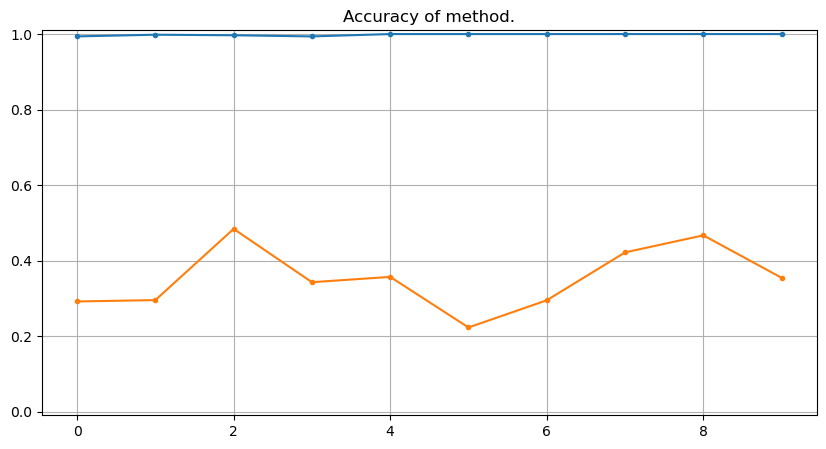

In [22]:
real_columns = [f"{sn}_real" for sn in style_names]
gen_columns = [f"{sn}_gen" for sn in style_names]

real_valid_accs = tstr_stats[real_columns].values.reshape((-1,))
gen_valid_accs = tstr_stats[gen_columns].values.reshape((-1,))


plt.figure(figsize=(10, 5))
plt.title("Accuracy of method.")

plt.plot(real_valid_accs, '.-')
plt.plot(gen_valid_accs, '.-')
plt.ylim((-0.01, 1.01))
plt.xticks()
plt.grid()
plt.show()

# UMAP Evaluation

In [3]:
def get_batches(dset, n_batches):
    _arr = np.array([c[0] for c in dset.take(n_batches)])
    return _arr.reshape((-1, _arr.shape[-2], _arr.shape[-1]))

def multi_umap_plot(real_styles, gen_styles):
    n_styles = len(real_styles)
    
    cmap = plt.get_cmap("tab20")
    colors = cmap(np.linspace(0, 1, n_styles*2))

    concatenated = tf.concat((real_styles, gen_styles), 0)
    shape = concatenated.shape
    print()

    # concatenated = tf.reshape(concatenated, (-1,shape[-2], shape[-1]))

    # concatenated = tf.transpose(concatenated, (0, 2, 1))
    # concatenated = tf.reshape(concatenated, (concatenated.shape[0], -1))
    
    # # for i in range(n_styles):
    # #     plt.plot(concatenated[i*shape[1]])

    # # # Normalize all sequences for the reducer.
    # _mean, _std = tf.math.reduce_mean(concatenated), tf.math.reduce_std(concatenated)
    # concatenated = (concatenated - _mean)/_std

    # reducer = umap.UMAP(n_neighbors=10, min_dist=0.5) 
    # reduced = reducer.fit_transform(concatenated)
    
    # reduced = reduced.reshape((2*n_styles, -1, 2))
    
    # plt.figure(figsize=(18, 10))
    # for i in range(n_styles):
    
    #     plt.scatter(reduced[i, :, 0], reduced[i, :, 1], label=f"Real Style {i+ 1}", alpha=0.5, color=colors[2*i])
    #     plt.scatter(reduced[n_styles+ i, :, 0], reduced[n_styles+ i, :, 1], label=f"Generated Style {i+ 1}", alpha=0.5, color=colors[2*i+1 ])

    # plt.grid()
    # plt.title(f"UMAP Reduction on Time Series", fontsize=15)
    # plt.ylabel("y_umap", fontsize=15)
    # plt.xlabel("x_umap", fontsize=15)
    # plt.legend()
    # plt.show()

In [4]:
real_batches = []
fake_batches = []

for i, style_ in enumerate(style_names):
    real_style_batch = get_batches(real_style_dataset[f"{style_}_valid"], 5)
    fake_style_batch = get_batches(fake_style_dataset[f"{style_}_valid"], 5)
    
    multi_umap_plot(real_style_batch, fake_style_batch)
#     real_batches.append(real_style_batch)
#     fake_batches.append(fake_style_batch)
     
# real_batches = np.array(real_batches)     
# fake_batches = np.array(fake_batches)  
   

NameError: name 'style_names' is not defined

In [38]:
def tsne_plot(real_styles, gen_styles):
    n_styles = len(real_styles)
    
    cmap = plt.get_cmap("tab20")
    colors = cmap(np.linspace(0, 1, n_styles*2))

    concatenated = tf.concat((real_styles, gen_styles), 0)
    shape = concatenated.shape
    concatenated = tf.reshape(concatenated, (-1, shape[-2], shape[-1]))

    concatenated = tf.transpose(concatenated, (0, 2, 1))
    concatenated = tf.reshape(concatenated, (concatenated.shape[0], -1))

    # # Normalize all sequences for the reducer.
    _mean, _std = tf.math.reduce_mean(concatenated), tf.math.reduce_std(concatenated)
    concatenated = (concatenated - _mean)/_std

    reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=150)
    reduced = reducer.fit_transform(concatenated)
    
    reduced = reduced.reshape((2*n_styles, -1, 2))
    
    plt.figure(figsize=(18, 10))
    for i in range(n_styles):
    
        plt.scatter(reduced[i, :, 0], reduced[i, :, 1], label=f"Real Style {i+ 1}", alpha=0.5, color=colors[2*i])
        plt.scatter(reduced[n_styles+ i, :, 0], reduced[n_styles+ i, :, 1], label=f"Generated Style {i+ 1}", alpha=0.5, color=colors[2*i+1 ])

    plt.grid()
    plt.title(f"UMAP Reduction on Time Series", fontsize=15)
    plt.ylabel("y_umap", fontsize=15)
    plt.xlabel("x_umap", fontsize=15)
    plt.legend()
    plt.show()

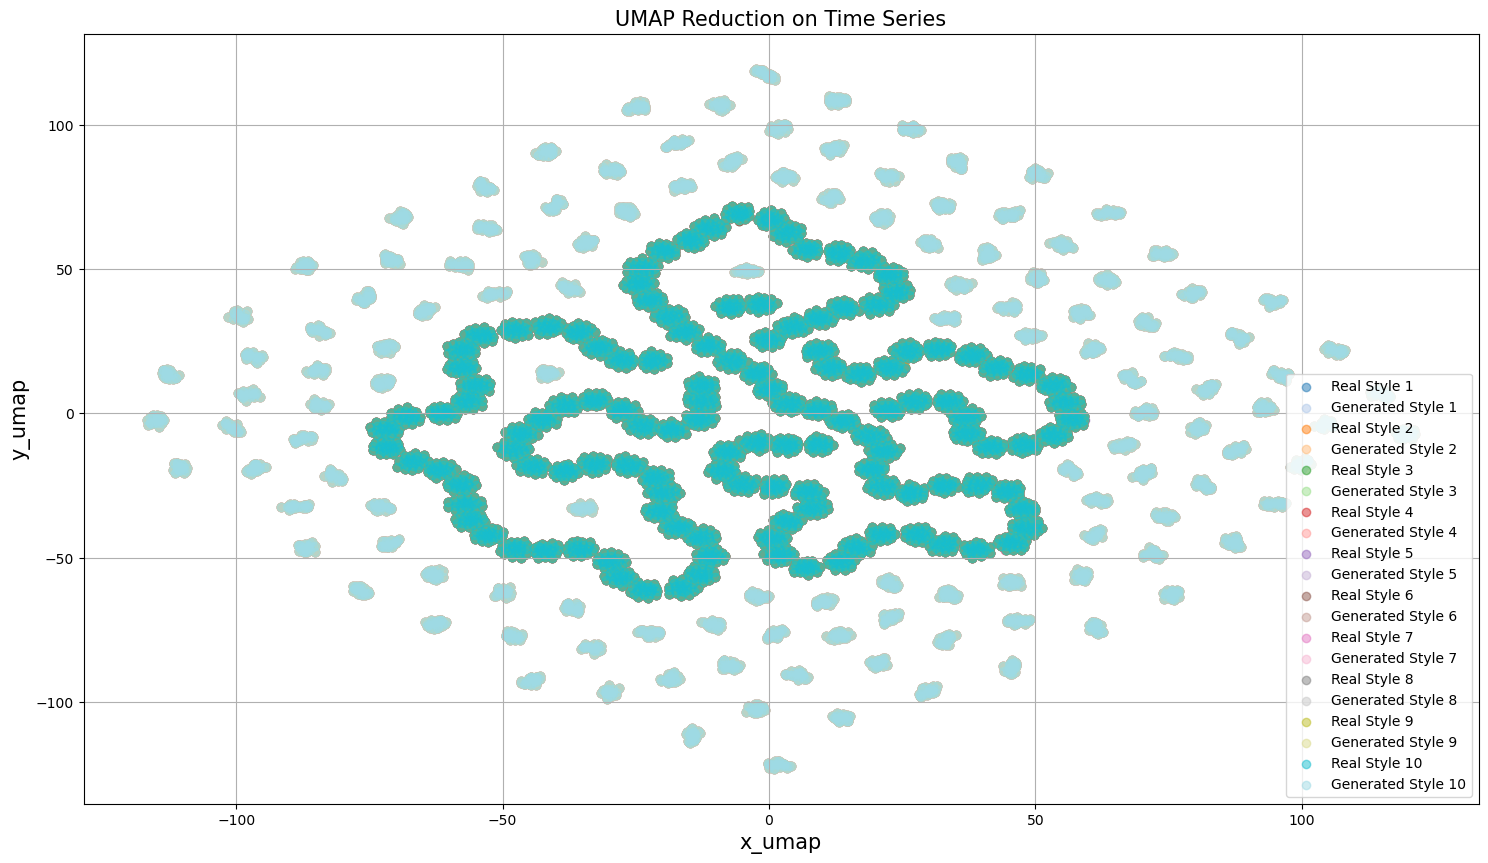

In [39]:
tsne_plot(real_batches, fake_batches)

In [15]:
def time_shift_evaluation(big_batch):
    return [simple_metric.estimate_time_shift(big_batch, 0, i) for i in range(big_batch.shape[-1])]

In [16]:
generations = []
style_sequences = []

real_noise_metric, gen_noise_metric = [], []
real_ampl_metric, gen_ampl_metric = [], []
real_ts_metric, gen_ts_metric = [], []

for style_dset_path in training_arguments["style_datasets"]:
    print(f"Generate form dataset {style_dset_path}")
    content_batch, style_batch = load_valid_batches(training_arguments['dset_content'], style_dset_path)
    gen_seq = generate(content_batch, style_batch, ce, se, de)
    
    real_noise_metric.append(simple_metric.simple_metric_on_noise(style_batch)[1])
    gen_noise_metric.append(simple_metric.simple_metric_on_noise(gen_seq)[1])
    
    real_ampl_metric.append(simple_metric.extract_amplitude_from_signals(style_batch))
    gen_ampl_metric.append(simple_metric.extract_amplitude_from_signals(gen_seq))
    
    real_ts_metric.append(time_shift_evaluation(style_batch))
    gen_ts_metric.append(time_shift_evaluation(gen_seq))
    
    style_sequences.append(style_batch)
    generations.append(gen_seq)
    
generations = np.array(generations)
style_sequences = np.array(style_sequences)

Generate form dataset data/simulated_dataset/amplitude_shift/1.0_1.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/2.0_2.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/3.0_3.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/4.0_4.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/5.0_5.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/6.0_6.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/7.0_7.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/8.0_8.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/9.0_9.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/10.0_10.0.h5


In [17]:
# c_encoded = ce(content_batch)
# plt.figure()
# for i in range(0, 100):
#     plt.scatter(c_encoded[i,:, 0], c_encoded[i,:, 1])

In [18]:
# seq_idx = 0
# style_idx = 9

# for seq_idx in range(0, 100, 10):
#     plt.figure()

#     ax = plt.subplot(311)
#     ax.set_title("content sequence")
#     plt.plot(content_batch[seq_idx])

#     ax = plt.subplot(312)
#     ax.set_title("style sequence")
#     plt.plot(style_sequences[style_idx][0])

#     ax = plt.subplot(313)
#     ax.set_title("generated sequence")
#     plt.plot(generations[style_idx][seq_idx])

#     plt.show()


# Amplitude Metric plot

In [19]:



plt.figure(figsize=(18, 8))
plt.title("Result on Extracted Amplitudes")
plt.plot(np.mean(real_ampl_metric, axis=-1), '.-', label='Real Amplitude')
plt.plot(np.mean(gen_ampl_metric, axis=-1), '.-', label='Real Amplitude')

plt.legend()
plt.grid()

# Extract Time Shift

In [20]:

# plt.figure(figsize=(18, 8))
# plt.title("Result on Extracted Time Shift")
# plt.plot(np.mean(real_ts_metric, axis=-1), '.-', label='Real Time shift')
# plt.plot(np.mean(gen_ts_metric, axis=-1), '.-', label='Real Time Shift')

# plt.legend()
# plt.grid()

# Extracted Noise

In [21]:
# plt.figure(figsize=(18, 8))
# plt.title("Result on Extracted Amplitudes")
# plt.plot(np.mean(real_noise_metric, axis=-1), '.-', label='Extracted Noise on Real')
# plt.plot(np.mean(gen_noise_metric, axis=-1), '.-', label='Extracte Noise on Fake')

# plt.legend()
# plt.grid()